In [1]:
# Import libraries
import os
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt

from utils.graph import *
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Activation, Conv2D, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization

2023-12-22 23:11:12.170239: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-22 23:11:12.170284: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-22 23:11:12.188097: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-22 23:11:12.235433: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-22 23:11:12.902841: W tensorflow/compiler/tf2

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=8192)]
        )

2023-12-22 23:11:13.999763: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-22 23:11:14.074029: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-22 23:11:14.074171: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
data_dir = 'mosquitoes-dataset/'
test_dir = 'test-dataset/'
model_dir = 'models/'

In [4]:
tf.random.set_seed(1234)
random.seed(1234)
np.random.seed(1234)

# Preprocessing

In [5]:
IMG_DIM = 224
IMG_SIZE = (IMG_DIM, IMG_DIM)
IMG_SHAPE = IMG_SIZE + (3,)

In [6]:
BATCH_SIZE = 32

In [7]:
class_names = sorted(os.listdir(data_dir))

In [8]:
class_num = len(class_names)

In [9]:
# Resize and normalize
resize_and_normalize = tf.keras.Sequential(
    [
        tf.keras.layers.Resizing(IMG_DIM, IMG_DIM),
        tf.keras.layers.Rescaling(1./255),
    ]
)

2023-12-22 23:11:14.132423: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-22 23:11:14.132604: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-22 23:11:14.132737: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [10]:
# Data augmentation
data_augment = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip('horizontal_and_vertical'),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomContrast(0.2),
    ]
)

In [11]:
# Data preparation wrapper
AUTOTUNE = tf.data.AUTOTUNE


def prepare(ds, augment=False):
    if augment:
        ds = ds.map(lambda x, y: (data_augment(x), y),
                    num_parallel_calls=AUTOTUNE)

    ds = ds.map(lambda x, y: (resize_and_normalize(x), y),
                num_parallel_calls=AUTOTUNE)

    ds.prefetch(buffer_size=AUTOTUNE)
    return ds

# Create dataset

In [12]:
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=IMG_SIZE,
    seed=1234,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset='both',
)

Found 1000 files belonging to 2 classes.
Using 800 files for training.
Using 200 files for validation.


In [13]:
train_ds = prepare(train_ds, augment=True)
val_ds = prepare(val_ds)

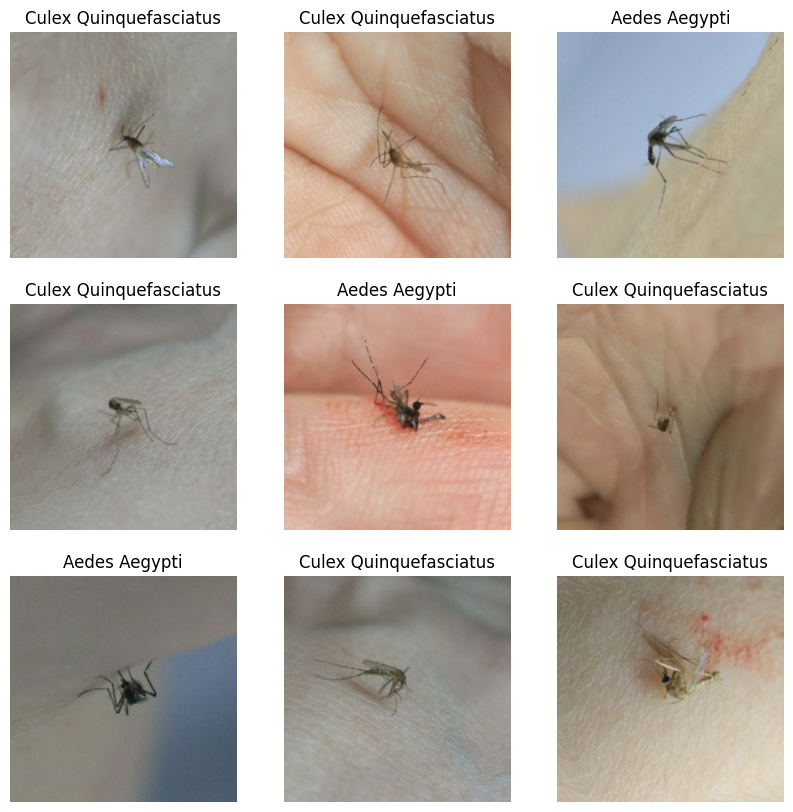

In [14]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i]])
        plt.axis('off')

# Build model

In [15]:
model = Sequential()

In [16]:
model.add(InputLayer(input_shape=IMG_SHAPE))

model.add(Conv2D(32, (3, 3), 1))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(GlobalAveragePooling2D())
model.add(Dense(class_num, activation='softmax'))

In [17]:
base_learning_rate = 1e-4

In [18]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 32)      128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)     

# Train model

In [20]:
history = model.fit(
    train_ds,
    epochs=25,
    validation_data=val_ds,
)

Epoch 1/25


2023-12-22 23:11:17.061781: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-12-22 23:11:17.962441: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-22 23:11:19.635556: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f476e0a5080 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-22 23:11:19.635571: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2023-12-22 23:11:19.643036: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1703261479.718268   10148 device_compiler.h:186] Compiled cluster using 

25/25 [==============================] - 8s 80ms/step - loss: 0.7072 - accuracy: 0.4875 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 2/25
25/25 [==============================] - 2s 64ms/step - loss: 0.6864 - accuracy: 0.5263 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 3/25
25/25 [==============================] - 2s 66ms/step - loss: 0.6701 - accuracy: 0.5700 - val_loss: 0.6928 - val_accuracy: 0.5100
Epoch 4/25
25/25 [==============================] - 2s 66ms/step - loss: 0.6652 - accuracy: 0.6062 - val_loss: 0.6923 - val_accuracy: 0.5350
Epoch 5/25
25/25 [==============================] - 2s 66ms/step - loss: 0.6541 - accuracy: 0.6037 - val_loss: 0.6900 - val_accuracy: 0.5550
Epoch 6/25
25/25 [==============================] - 2s 64ms/step - loss: 0.6349 - accuracy: 0.6463 - val_loss: 0.6874 - val_accuracy: 0.6200
Epoch 7/25
25/25 [==============================] - 2s 64ms/step - loss: 0.6223 - accuracy: 0.6250 - val_loss: 0.6847 - val_accuracy: 0.5600
Epoch 8/25
25/25 [======

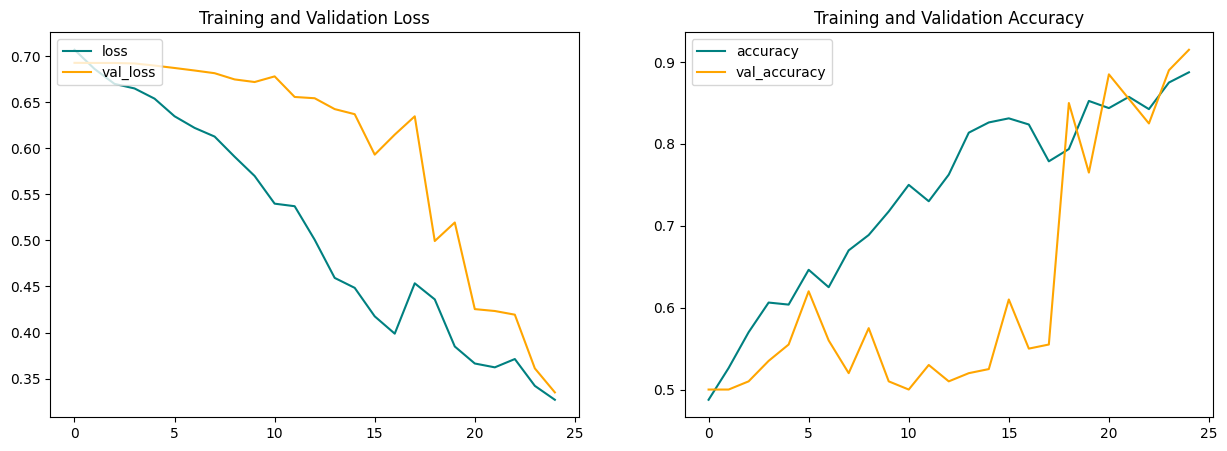

In [21]:
draw_learning_curve(history)

# Evaluation

In [22]:
test_ds_count = 0
for r, d, f in os.walk(test_dir):
    test_ds_count += len(f)

In [23]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=1234,
    image_size=IMG_SIZE,
    batch_size=test_ds_count,
)

Found 193 files belonging to 2 classes.


In [24]:
test_ds = prepare(test_ds)

In [25]:
image_batch, label_batch = test_ds.as_numpy_iterator().next()
yhat = model.predict_on_batch(image_batch)

yhat = tf.nn.softmax(yhat)

label_yhat = np.empty(0, dtype=int)
for i in range(test_ds_count):
    label_yhat= np.append(label_yhat, np.argmax(yhat[i]))

print('True labels:\n', label_batch)
print('Predicted labels:\n', label_yhat)

True labels:
 [0 0 1 1 0 1 1 0 0 0 0 0 1 1 0 1 1 1 0 0 1 0 1 1 1 0 0 0 0 0 1 1 0 0 1 0 0
 1 0 0 0 1 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 1 1 1 0 0 1 0 1 0 1 0 0 1 0 1 1
 1 1 0 1 0 0 1 1 0 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 0 0 1 1 1 0 0 1 0 0 0 1
 0 0 1 0 0 1 0 1 1 0 1 0 1 1 1 0 1 1 0 1 0 1 1 0 0 1 0 1 1 1 0 1 0 0 0 1 0
 0 1 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1 1 0 1 0 0 0 1 1 1 0 1 0 1
 1 1 1 1 0 0 1 1]
Predicted labels:
 [0 0 1 1 0 1 1 0 0 0 0 0 1 1 0 1 0 1 0 0 1 0 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0
 1 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 0 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1
 1 1 0 1 0 0 1 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0 1
 0 0 1 0 0 1 0 0 1 0 1 0 1 1 1 0 1 1 0 1 0 1 1 0 0 1 0 0 1 1 0 1 0 0 0 1 0
 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1 0 0 0 0 0 0 1 1 1 0 1 0 1
 1 1 1 1 0 0 0 1]


In [26]:
cm = confusion_matrix(label_batch, label_yhat)
print(cm)

[[102   0]
 [ 14  77]]


In [27]:
norm_cm = confusion_matrix(label_batch, label_yhat, normalize='true')
norm_cm = np.round(norm_cm, 2)
print(norm_cm)

[[1.   0.  ]
 [0.15 0.85]]


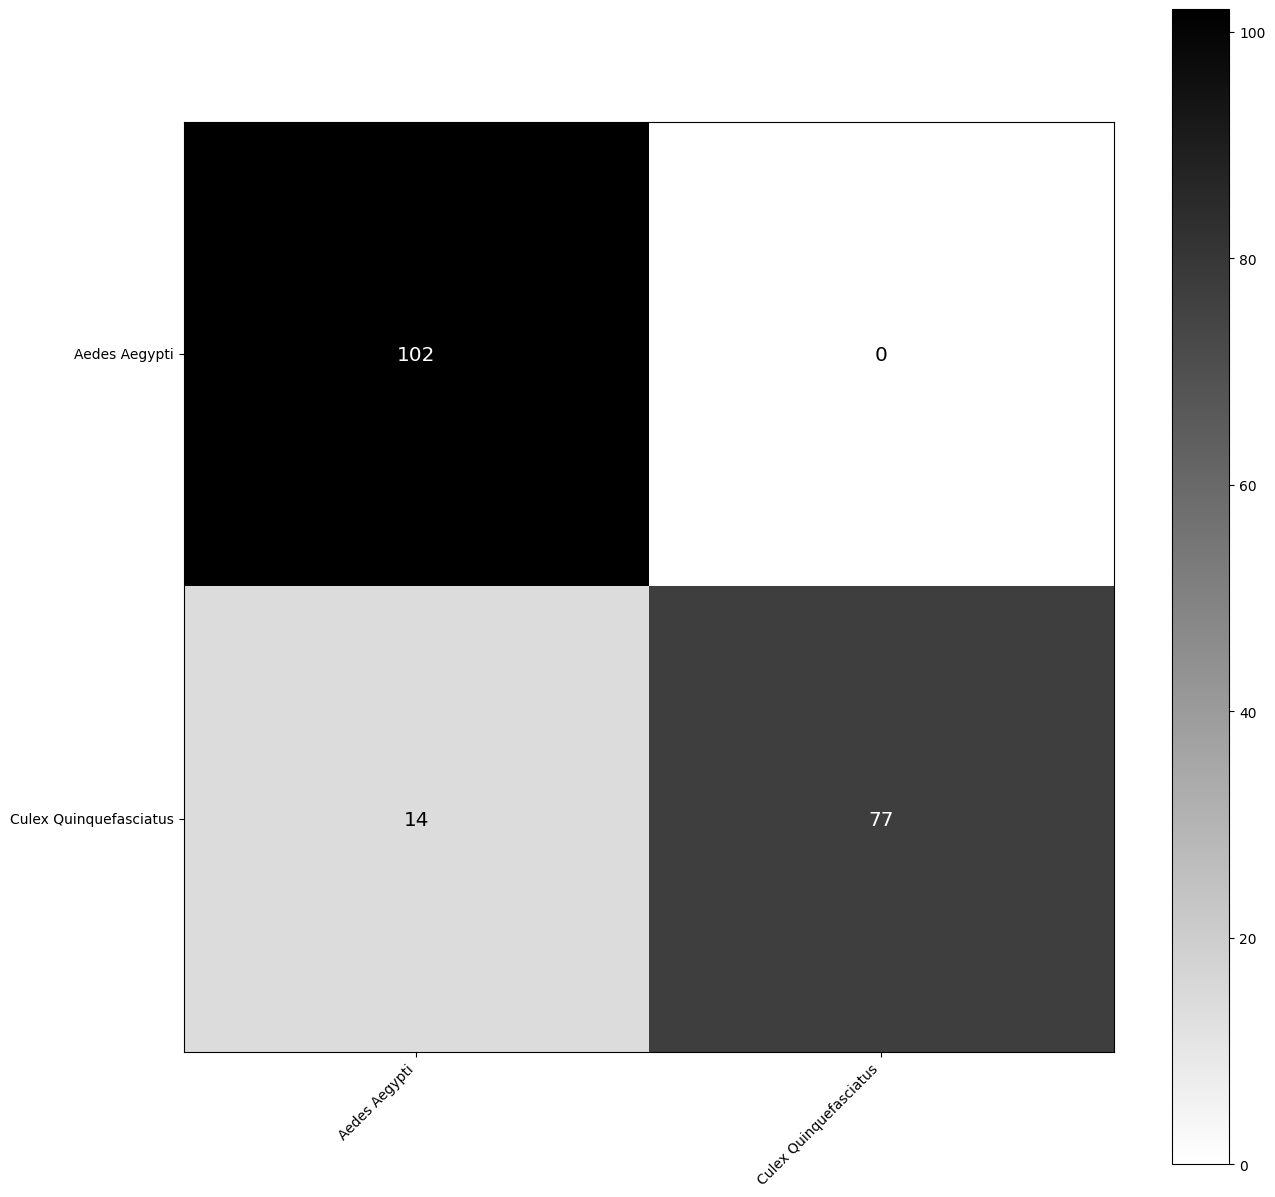

In [28]:
draw_confusion_matrix(cm, class_names)

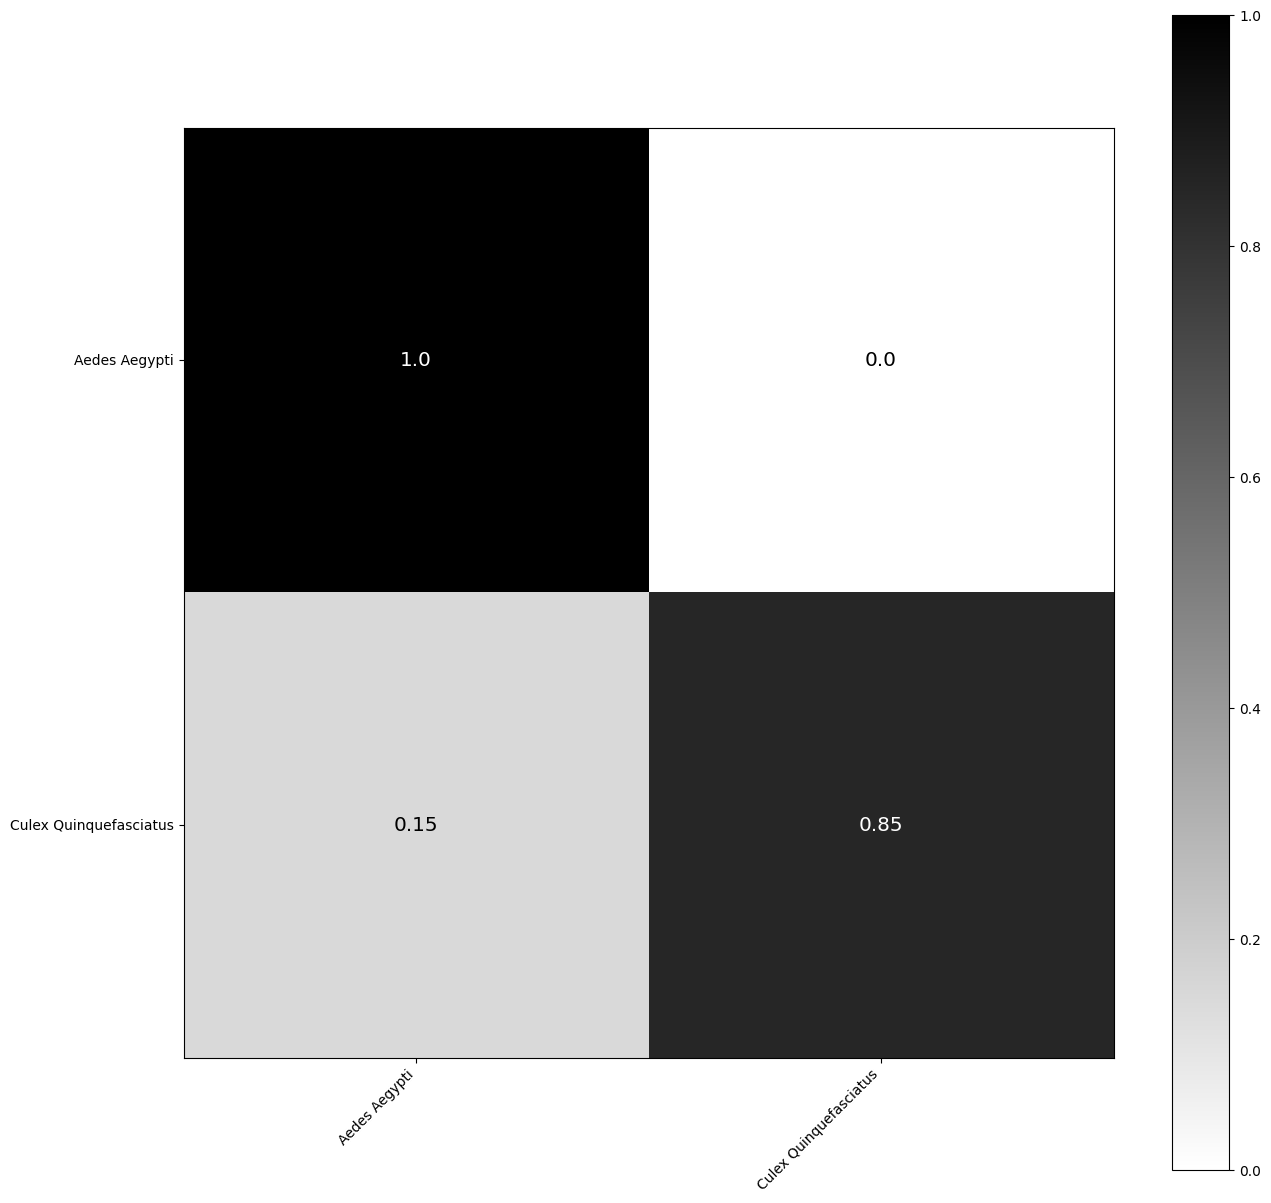

In [29]:
draw_confusion_matrix(norm_cm, class_names)

In [30]:
model.save(os.path.join(model_dir, 'model.h5'))

/home/bit/Workpaces/mosquitoes-classification/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
